In [1]:
# !pip install pyscf==2.6.0
# !pip install openfermion==1.6.1
# !echo cuda-quantum | sudo -S apt-get install -y cuda-toolkit-11.8 && python -m pip install cupy==13.1.0
# !pip install git+https://github.com/yfhuang93/ipie/tree/msd_gpu
# !pip install ipie==0.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyscf import gto, scf, ao2mo, mcscf

from openfermion import jordan_wigner
from openfermion import generate_hamiltonian

from src.vqe_cudaq_qnp import VqeQnp
from src.vqe_cudaq_qnp import get_cudaq_hamiltonian
from src.utils_ipie import get_coeff_wf, gen_ipie_input_from_pyscf_chk


from ipie.config import config
config.update_option("use_gpu", False)
from ipie.hamiltonians.generic import Generic as HamGeneric
from ipie.qmc.afqmc import AFQMC
from ipie.systems.generic import Generic
from ipie.trial_wavefunction.particle_hole import ParticleHole
from ipie.analysis.extraction import extract_observable

In [3]:
# Define the geometry and the basis set for the molecule
atom = "systems/O3_spin_0/geo.xyz"
basis = "cc-pVQZ"

# Define the active space 
num_active_orbitals = 6
num_active_electrons = 8
spin = 0
charge = 0

# Specify the chkfile for pyscf
file_chk = "scf_mwe.chk"

# Define the backend for cudaq - used later for computing the AFMQC Hamiltonian
target = "nvidia"

# Define the number of layers for VQE
n_vqe_layers = 1


In [4]:
# PYSCF 
# Define the molecule and run Hartee-Fock
molecule = gto.M(
    atom=atom,
    spin=spin,
    charge=charge,
    basis=basis,
    verbose=0
)

mol_nelec = molecule.nelec
hartee_fock = scf.ROHF(molecule)
hartee_fock.chkfile = file_chk
hartee_fock.kernel()

-224.35854603286512

In [5]:
## VQE 

# Run a casci simulation for computing the Hamiltonian in the active space
my_casci = mcscf.CASCI(hartee_fock, num_active_orbitals, num_active_electrons)
ss = (molecule.spin / 2 * (molecule.spin / 2 + 1))
my_casci.fix_spin_(ss=ss)

e_tot, e_cas, fcivec, mo_output, mo_energy = my_casci.kernel()

# Compute one-body and two-body integrals for the Hamiltonian
h1, energy_core = my_casci.get_h1eff()
h2 = my_casci.get_h2eff()
h2_no_symmetry = ao2mo.restore('1', h2, num_active_orbitals)
tbi = np.asarray(h2_no_symmetry.transpose(0, 2, 3, 1), order='C')

# Compute the Hamiltonian and convert it to a cudaq operator
mol_ham = generate_hamiltonian(h1, tbi, energy_core.item(), EQ_TOLERANCE=1e-8)
jw_hamiltonian = jordan_wigner(mol_ham)
hamiltonian_cudaq, energy_core = get_cudaq_hamiltonian(jw_hamiltonian)

n_qubits = 2 * num_active_orbitals

# Define some options for the VQE
options = {'maxiter': 100,
           'energy_core': energy_core,
           'return_final_state_vec': True}

vqe = VqeQnp(n_qubits=n_qubits,
             n_layers=n_vqe_layers,
             num_active_electrons=num_active_electrons,
             spin=spin,
             target=target)

results = vqe.run_vqe_cudaq(hamiltonian_cudaq, options=options)

# Best energy from VQE
energy_optimized = results['energy_optimized']

# Final state vector
final_state_vector = results["state_vec"]

# List with the energies for all the optimizer iterations
energies_vqe = results["callback_energies"]

# np.savetxt("wave_function.dat", final_state_vector)
# final_state_vector = np.loadtxt("wave_function.dat", dtype=np.complex_)


# Using cudaq optimizer
# Num Params: 10
# Qubits: 12
# N_layers: 1
# Energy after the VQE: -224.41095438546748


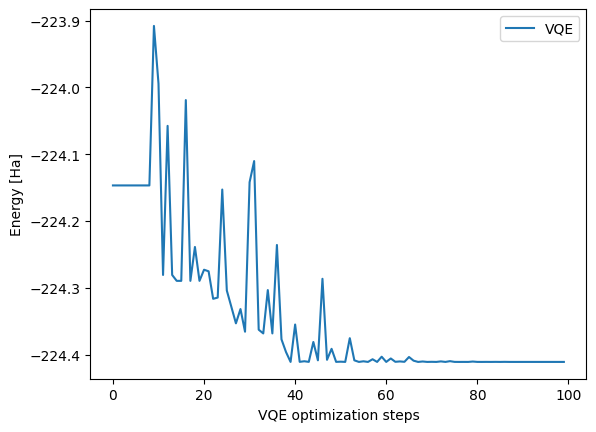

In [6]:
plt.xlabel("VQE optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(energies_vqe, label="VQE")
plt.legend()

In [7]:
#AFQMC

# Generate the input Hamiltonian for ipie from the chk file from pyscf
ipie_ham  = gen_ipie_input_from_pyscf_chk(file_chk,
                                          mcscf=True,
                                          chol_cut=1e-5)

h1e, cholesky_vectors, e0  = ipie_ham 

num_basis = cholesky_vectors.shape[1]
num_chol = cholesky_vectors.shape[0]

system = Generic(nelec=mol_nelec)

ham = HamGeneric(
    np.array([h1e, h1e]),
    cholesky_vectors.transpose((1, 2, 0)).reshape((num_basis * num_basis, num_chol)),
    e0,
)
####################

# Build the trial wavefunction from the state vector computed via VQE
wavefunction = get_coeff_wf(final_state_vector,
                            n_elec=(num_active_electrons_alpha, num_active_electrons_beta)
                           )

trial = ParticleHole(
    wavefunction,
    mol_nelec,
    num_basis,
    num_dets_for_props=len(wavefunction[0]),
    verbose=False)  #set to true if needed

trial.compute_trial_energy = True
trial.build()
trial.half_rotate(ham)
####################

 # Performing modified Cholesky decomposition on ERI tensor.
# Generating Cholesky decomposition of ERIs.
# max number of cholesky vectors = 1650
# iteration     0: delta_max = 4.785886
# iteration     1: delta_max = 4.77337369e+00: time = 5.96833229e-03
# iteration     2: delta_max = 4.71704611e+00: time = 2.08249092e-02
# iteration     3: delta_max = 9.09979426e-01: time = 2.06835270e-02
# iteration     4: delta_max = 9.00399998e-01: time = 2.70864964e-02
# iteration     5: delta_max = 8.44374457e-01: time = 2.17354298e-02
# iteration     6: delta_max = 4.53333155e-01: time = 2.44574547e-02
# iteration     7: delta_max = 4.53243727e-01: time = 1.74324512e-02
# iteration     8: delta_max = 4.53062225e-01: time = 2.29613781e-02
# iteration     9: delta_max = 3.28579026e-01: time = 2.61831284e-02
# iteration    10: delta_max = 3.27545060e-01: time = 2.47371197e-02
# iteration    11: delta_max = 3.27544777e-01: time = 2.57456303e-02
# iteration    12: delta_max = 3.27531397e-01: time = 2

In [8]:
# Set the AFQMC parameters (num_walkers, num_blocks,...) here 
afqmc_msd = AFQMC.build(
    mol_nelec,
    ham,
    trial,
    num_walkers=100,
    num_steps_per_block=25,
    num_blocks=10,
    timestep=0.005,
    stabilize_freq=5,
    seed=96264512,
    pop_control_freq=5,
    verbose=False,
)

# Run the AFQMC
afqmc_msd.run()
afqmc_msd.finalise(verbose=False)

# random seed is 96264512
            Block                   Weight            WeightFactor            HybridEnergy                  ENumer                  EDenom                  ETotal                  E1Body                  E2Body
                0   1.0000000000000000e+02  1.0000000000000000e+02  0.0000000000000000e+00 -2.2441103376010378e+04  1.0000000000000000e+02 -2.2441103376010378e+02 -3.7639640464797509e+02  1.5198537088787131e+02
                1   4.2263949494833156e+02  1.4123732991295919e+03 -1.1722826958744169e+02 -2.2488895623485725e+04  9.9999999999999986e+01 -2.2488895623485729e+02 -3.7640399963117522e+02  1.5151504339631799e+02
                2   9.9921372260332589e+01  3.8265559927617028e+02 -1.1719114855770309e+02 -2.2496531910420246e+04  9.9999999999999986e+01 -2.2496531910420251e+02 -3.7661847035338923e+02  1.5165315124918672e+02
                3   1.0036843763211981e+02  1.0063509507079348e+02 -1.1756329503464168e+02 -2.2509966117578664e+04  1.000000000000

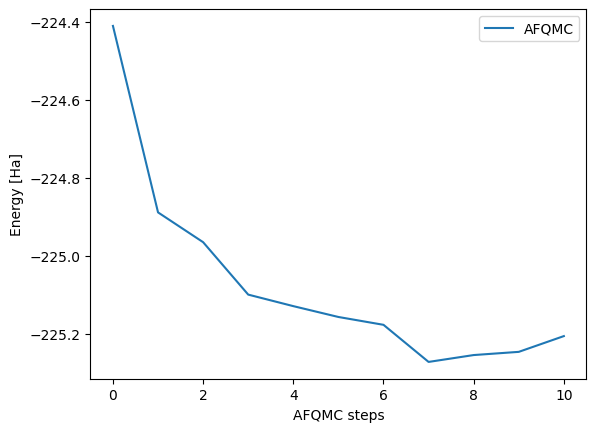

In [9]:
qmc_data = extract_observable(afqmc_msd.estimators.filename, "energy")
plt.xlabel("AFQMC steps")
plt.ylabel("Energy [Ha]")
plt.plot(qmc_data["ETotal"], label="AFQMC")
plt.legend()

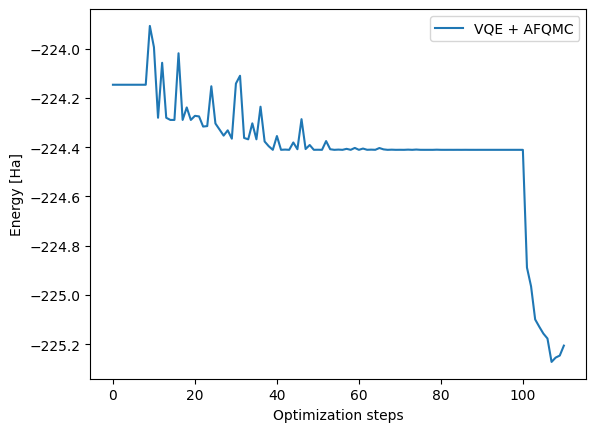

In [10]:
x = energies_vqe + list(qmc_data["ETotal"])
y = list(range(len(x)))

plt.xlabel("Optimization steps")
plt.ylabel("Energy [Ha]")
plt.plot(y, x, label="VQE + AFQMC")
plt.legend()